# Analysis Twitter data

How can we study a social media as Twitter. The strategy is generally similar.

- data collection (scrapping or API)
- data curation  / management
- exploration of the curated data
- visualisations and advanced analysis

## Step 1 - Collecting data

In this case, I use `twarc` with commandline. Others options exist, for instance as a librairy.

`twarc2 search --archive '#lancetgate OR lancetgate' --end-time "2023-01-01" --start-time "2020-02-01" results_lg.jsonl`

To get the data in a csv format, I use another command line

`twarc2 csv results_lg.jsonl results_lg.csv`

We have a dataset with the tweets.

## Step 2 - exploring the data

Let's use `Pandas`

In [1]:
import pandas as pd

And load the data

In [2]:
data = pd.read_csv("./results_lg.csv", low_memory=False,dtype={'entities.cashtags':"object"})
data.shape

(135783, 83)

In [3]:
data.head()

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,in_reply_to_username,retweeted_user_id,retweeted_username,...,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,matching_rules,__twarc.retrieved_at,__twarc.url,__twarc.version
0,1609305609211416578,1609305609211416578,NaN,1.608943e+18,NaN,1182419452710838272,NaN,NaN,1.531881e+18,TakeHeight,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
1,1609279128456531969,1609279128456531969,NaN,1.609278e+18,NaN,1352449995652296704,NaN,NaN,1.503472e+18,Jikkyleaks,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
2,1609278946524426244,1609278946524426244,NaN,1.602335e+18,NaN,3695081546,NaN,NaN,8.037884e+17,JamesTodaroMD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
3,1609278733768364032,1609278733768364032,NaN,1.609278e+18,NaN,73928056,NaN,NaN,1.503472e+18,Jikkyleaks,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0
4,1609278314962911238,1608485547202289664,1.609268e+18,NaN,NaN,1503472017412034562,8.293770e+17,DrLizaMD,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-16T21:04:47+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.13.0


What are the information we have ?

In [4]:
data.columns

Index(['id', 'conversation_id', 'referenced_tweets.replied_to.id',
       'referenced_tweets.retweeted.id', 'referenced_tweets.quoted.id',
       'author_id', 'in_reply_to_user_id', 'in_reply_to_username',
       'retweeted_user_id', 'retweeted_username', 'quoted_user_id',
       'quoted_username', 'created_at', 'text', 'lang', 'source',
       'public_metrics.impression_count', 'public_metrics.reply_count',
       'public_metrics.retweet_count', 'public_metrics.quote_count',
       'public_metrics.like_count', 'reply_settings', 'edit_history_tweet_ids',
       'edit_controls.edits_remaining', 'edit_controls.editable_until',
       'edit_controls.is_edit_eligible', 'possibly_sensitive',
       'withheld.scope', 'withheld.copyright', 'withheld.country_codes',
       'entities.annotations', 'entities.cashtags', 'entities.hashtags',
       'entities.mentions', 'entities.urls', 'context_annotations',
       'attachments.media', 'attachments.media_keys',
       'attachments.poll.duration_mi

#### Temporal evolution

In [5]:
data["date"] = pd.to_datetime(data['created_at'])
data["num"] = 1

Visualisation

<AxesSubplot:xlabel='date'>

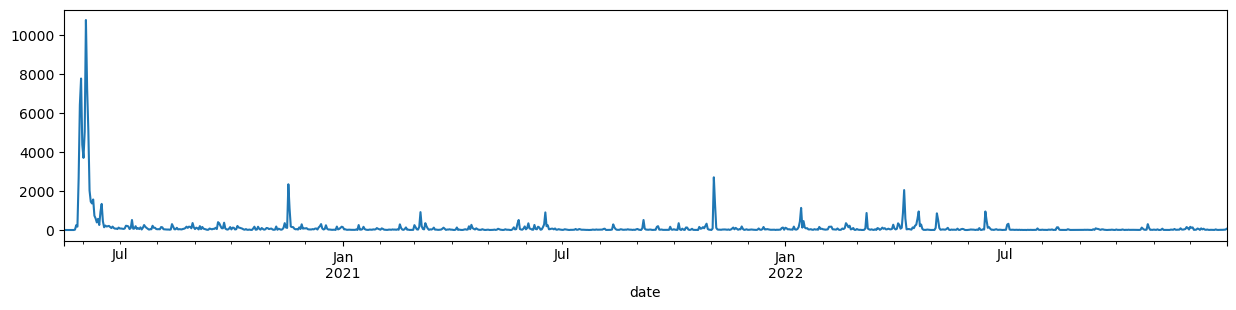

In [6]:
data.set_index("date").resample("d")["num"].sum().plot(figsize=(15,3))

How to investigate around those bursts ?

*Exercice : identify the topic of bursts*

For various reasons, we need to have a better look on tweet. We can build a small tool for visualisation.

In [7]:
import requests
class Tweet(object):
    def __init__(self, s):
        s = f"https://twitter.com/OReillyMedia/status/{s}"
        api = 'https://publish.twitter.com/oembed?url={}'.format(s)
        response = requests.get(api)
        self.text = response.json()["html"]

    def _repr_html_(self):
        return self.text

Testing it on a tweet

In [8]:
Tweet(data.iloc[1000]["id"])

#### Filter original tweets (without retweets)

In [9]:
f_or = pd.isnull(data['referenced_tweets.retweeted.id'])
f_or.sum()

21950

#### Identifying the main languages

In [10]:
data['lang'].value_counts().head()

fr     107930
en      20190
qme      1665
es       1627
und      1046
Name: lang, dtype: int64

We can check it is a French thing : https://trends.google.com/trends/explore?q=lancetgate

#### Identifying the main users

In [11]:
data['author.username'].value_counts().head()

Bif132             1308
julien0686          846
JaiRaison           425
Despeerad0s         389
FlaurentNeuhaus     374
Name: author.username, dtype: int64

Number of users

In [12]:
len(data['author.username'].unique())

41972

<AxesSubplot:>

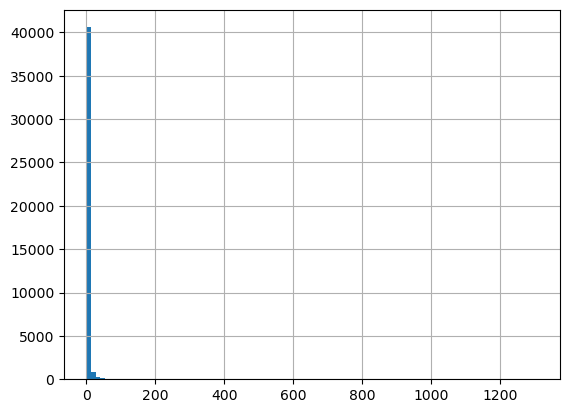

In [13]:
data['author.username'].value_counts().hist(bins=100)

A skew distribution ...

#### What are the most visible tweet

In [14]:
data[f_or][["id",'public_metrics.retweet_count']].sort_values('public_metrics.retweet_count',ascending=False).head()

,id,public_metrics.retweet_count
103829,1268115704311689218,3666
55820,1328611174993309696,2552
99175,1268231436932395010,2335
130765,1266401930789769217,2193
24421,1481687712046399488,2061


In [85]:
Tweet(1268115704311689218)

### Extract hashtags

(in this case, the metadata are not very friendly)

In [15]:
import re
def extract_hashtags(text):
    return re.findall("(#\w+)", text.lower())

In [16]:
data["hashtags"] = data['text'].str.lower().apply(extract_hashtags)

data["hashtags"]

In [17]:
data["hashtags"]

0                                             [#lancetgate]
1                                             [#lancetgate]
2                                             [#lancetgate]
3                                             [#lancetgate]
4                                             [#lancetgate]
                                ...                        
135778    [#ggrmc, #covidー19, #lancet, #raoult, #lancetg...
135779    [#bigpharma, #chloroquine, #remdesevir, #lance...
135780                                        [#lancetgate]
135781                                                   []
135782                                                   []
Name: hashtags, Length: 135783, dtype: object

## Step 3 : Creating networks

In [19]:
from itertools import combinations
import networkx as nx

### Non directed retweet

- A node is created if a user tweet or retweet
- A link is created if a user retweet another

In [20]:
pd.isnull(data["retweeted_username"].iloc[123])

True

In [21]:
network_retweets = nx.Graph()

for i, line in data.iterrows():
    
    user = str(line["author.username"])
    
    if not user in network_retweets.nodes:
        network_retweets.add_node(user, label=user, weight=1)
    else:
        network_retweets.nodes[user]["weight"] += 1    
        
    if pd.notnull(line["retweeted_username"]):

        reweet_user = str(line["retweeted_username"])
        
        if not reweet_user in network_retweets.nodes:
            network_retweets.add_node(reweet_user, label=reweet_user, weight=1)
        else:
            network_retweets.nodes[reweet_user]["weight"] += 1  

        if pd.notnull(reweet_user):
            if not network_retweets.has_edge(user, reweet_user):
                network_retweets.add_edge(user, reweet_user, weight=1)
            else:
                network_retweets[user][reweet_user]["weight"] += 1        

### hashtags

- 1-mode network
- 2 hashtags connected if mentionned in the same tweet

In [109]:
network_hashtags = nx.Graph()

for i, line in data.iterrows():
    for e in line["hashtags"]:
        if not e in network_hashtags.nodes:
            network_hashtags.add_node(e, label=e, weight=1)
        else:
            network_hashtags.nodes[e]["weight"] += 1
            
    for i, j in combinations(line["hashtags"], 2): 
        if not network_hashtags.has_edge(i, j):
            network_hashtags.add_edge(i, j, weight=1)
        else:
            network_hashtags[i][j]["weight"] += 1

## Step 4 : First visualisation

We can try do to dit directly in Python with dedicated tools

In [24]:
from ipysigma import Sigma

In [25]:
Sigma(network_retweets, node_size="weight")

Sigma(nx.Graph with 41,989 nodes and 86,526 edges)

In [117]:
Sigma(network_hashtags, node_size="weight")

Sigma(nx.Graph with 3,447 nodes and 22,460 edges)

Its huge networks, and the visualisation is not the best. We would like to simply them.

- remove the central node
- clustering

Or we can move to a dedicated software : Gephi

In [134]:
nx.write_graphml(network_retweets,"network_retweets.graphml")

## Step 5 : Statistics on the network

In [26]:
network_retweets

In [28]:
degrees = network_retweets.degree

<AxesSubplot:ylabel='Frequency'>

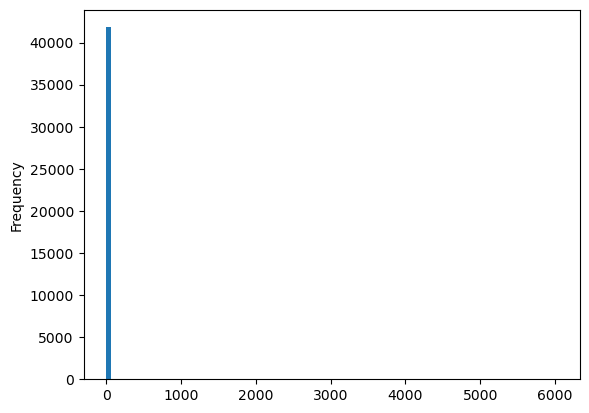

In [37]:
pd.DataFrame(list(degrees))[1].plot(kind="hist",bins=100)

In [39]:
nx.number_connected_components(network_retweets)

3709

Principal component

In [43]:
largest_cc = max(nx.connected_components(network_retweets), key=len)
len(largest_cc)

37661

Extract the component

In [45]:
largest_cc_network = nx.subgraph(network_retweets,largest_cc)

Calculate the density

In [46]:
nx.density(largest_cc_network)

0.00012107903440175127

Calculate the closeness centrality (could take some time)

In [49]:
largest_cc_network.nodes

NodeView(('Vieux_Rhone', 'TakeHeight', 'buddy25648539', 'Jikkyleaks', 'askwhymoreoften', 'JamesTodaroMD', 'LaLaRueFrench75', 'eliebre83', '32Secotine', 'FactAndSerious', 'IsabelleIsa2009', 'RobyFranois2', '34Galet', 'laurentblaisot', 'Cryptoexp06', 'aspi79463118', 'mydaphne', '1DavidStevenson', 'VingetX', 'OsteoSchmitt', 'emmanuelle_blin', 'le5ombr3', 'ink_caro', 'CedricUntel', 'Johndartois', 'Michel__LECLAIR', 'anonymo84', 'CLOUTECHRISTIN2', 'stanborowitz20', '80huit', 'derniertweet', 'JCPEREZCODEX', 'marsu35', 'Jeannemarie1309', 'erussal55', 'CSacced', 'loindevant', 'Zank_Keuz', 'maxalex79max', 'katell8', 'YvnCdric', 'SouchetGerald', 'YahiaouiChafika', 'AnnieTissot', 'mosquetayre', 'croute_de_pain', 'rob_majo', 'FRFAB66', 'B91Steph', 'FaisonsLes', 'LeParede_n', 'PacaraneM', 'visionterritoir', 'LeManu31', 'xazalbert', 'DaisyBelleTx', 'MCM67738662', 'Djolabrikol', 'cocomel_and_bft', 'ManuelDUPONT7', 'NataliaNausica', 'AlainTerstice', 'MisterOz5', 'm_zenonus', 'Bonnie_boys', 'IndiScipl'

In [54]:
nx.closeness_centrality(largest_cc_network,u="raoult_didier")

0.40169809710726173

Find the maximal clique

In [55]:
r = nx.find_cliques(largest_cc_network)

In [58]:
r = [i for i in r]

In [61]:
r[1]

['PatracqSerge', 'andrebercoff']

## Step 6 : Add attributes / transform network

One the exploration is done, we have more specific question, and we will go back to data ...

- Transforming the network : for instance, filter, subsample, etc.
- Adding information : categories, polarities (sentiment analysis)

#### Focus on the core

In [149]:
nx.selfloop_edges(network_hashtags)

<generator object selfloop_edges.<locals>.<genexpr> at 0x1eacc28f0>

In [164]:
#remove self-loops
network_hashtags.remove_edges_from(nx.selfloop_edges(network_hashtags))

r = nx.k_core(network_hashtags,k=3)

In [165]:
len(r.nodes),len(network_hashtags.nodes)

(2717, 3447)

#### Clustering

In [136]:
import networkx.algorithms.community as nx_comm 

clusters = nx_comm.louvain_communities(network_hashtags, seed=123, weight="weight")

In [145]:
pd.Series([len(i) for i in clusters]).value_counts()

1       78
2        5
3        4
4        4
10       3
7        3
11       3
12       2
8        2
5        2
51       1
139      1
80       1
1808     1
27       1
9        1
15       1
238      1
223      1
32       1
22       1
6        1
228      1
26       1
127      1
95       1
24       1
47       1
dtype: int64

Adding it to the network ? lets add a new class in each node, and the number of the class but only if there is at least 50 elements in it

## Go further


- directed networks of retweet ?
- links ?
- all words ?
- proximity with the bio of users ?
- can we get an information about the evolution of the network ? How ?